
<div align="center">
  <img src="https://raw.githubusercontent.com/JuanJoseBayonaSepulveda/Evidencia/main/capture/banner.jpeg" width="800" height="300">
</div>

# <center> **Proyecto IA2** </center>


In [ ]:
#@title **Importar las librerías que se usarán**
import os
import gc
import cv2
import random
import pandas as pd
import numpy as np
import urllib.request
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook, tnrange

from itertools import chain
from skimage.morphology import label
from skimage.transform import resize
from sklearn.model_selection import train_test_split
from skimage.io import imread, imshow, concatenate_images

import tensorflow as tf
from keras.optimizers import Adam
from keras.models import Model, load_model
from keras.layers import concatenate, add
from keras.layers.core import Lambda, RepeatVector, Reshape
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.layers.pooling import MaxPooling2D, GlobalMaxPool2D
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import os
from PIL import Image

path = "/content/drive/MyDrive/Hojas de tomate"

#categorias = os.listdir(path)

categorias = [
    "Tomato___Bacterial_spot",
    "Tomato___Early_blight",
    "Tomato___healthy",
    "Tomato___Late_blight",
    "Tomato___Leaf_Mold",
    "Tomato___Septoria_leaf_spot",
    "Tomato___Spider_mites Two-spotted_spider_mite",
    "Tomato___Target_Spot",
    "Tomato___Tomato_mosaic_virus",
    "Tomato___Tomato_Yellow_Leaf_Curl_Virus"
]
images = []
imagenes = []
labels = []

# Cargar las imágenes y las etiquetas
for categoria in categorias:
    for archivo in os.listdir(os.path.join(path, categoria)):
        img = Image.open(os.path.join(path, categoria, archivo))
        #img_resized = img.resize((224, 224))  # Cambiar el tamaño de las imágenes a (224, 224)
        images.append((img,categoria))
        img_array = np.array(img)  # Convertir la imagen en un arreglo numpy
        imagenes.append(img_array)
        labels.append(categoria)


In [ ]:
X = np.array(imagenes)
y = np.array(labels)

<ipython-input-4-e66f635b69ed>:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.array(imagenes)


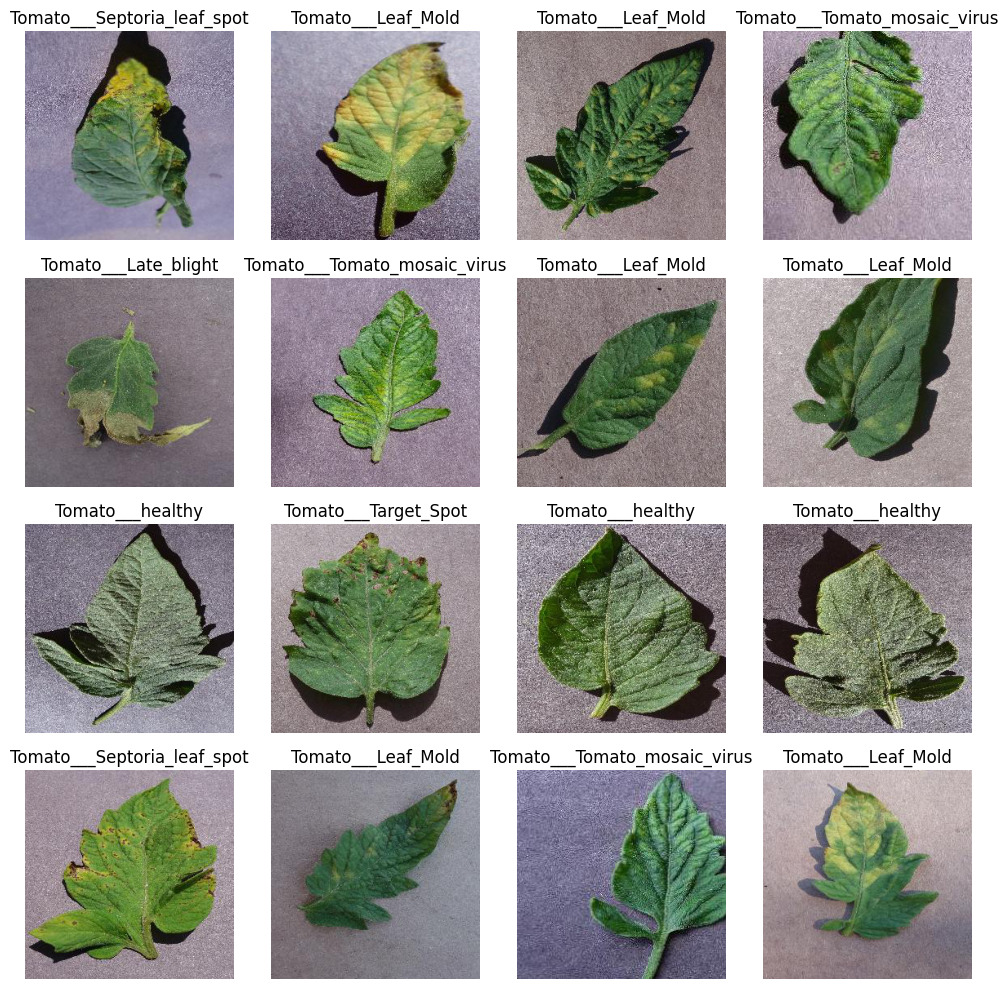

In [ ]:
import random
random.shuffle(images)
fig, axes = plt.subplots(4, 4, figsize=(10, 10))

for i, (img, categoria) in enumerate(images[:16]):
    row = i // 4
    col = i % 4
    axes[row, col].imshow(img)
    axes[row, col].set_title(categoria)
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()

In [ ]:
#@title Codificar etiquetas categóricas en valores numéricos

from sklearn.preprocessing import LabelEncoder

# Crear y ajustar el LabelEncoder
label_encoder = LabelEncoder()
label_encoder.fit(y)

# Codificar las etiquetas numéricamente
y = label_encoder.transform(y)

# Imprimir el número de clases
num_classes = len(label_encoder.classes_)
print("Número de clases:", num_classes)


Número de clases: 10


In [ ]:
#@title Se realiza la mezcla aleatoria de los datos y las etiquetas

# Obtener el índice de mezcla aleatoria
indices = np.random.permutation(len(X))

# Mezclar los datos y las etiquetas usando los índices
X = X[indices]
y = y[indices]


In [ ]:
#@title Tratamiento de los datos

#Resize de las imágenes
Tam_image=128
x = []
for img in X:
    resized_img = cv2.resize(img, (Tam_image, Tam_image))
    x.append(resized_img)

# Dividir el dataset en conjuntos de entrenamiento y prueba
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

#Pasamos los datos a float y Normalizamos
x_train = np.array(X_train).astype('float32') / 255.0
x_test = np.array(X_test).astype('float32') / 255.0

# Realizar el one-hot encoding de las etiquetas
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# Cantidad de datos
print(f"X_train shape: {x_train.shape}, Y_train shape: {y_train.shape}")
print(f"X_test shape:  {x_test.shape},  Y_test shape:  {y_test.shape} \n")
# Escala
print(f"X_train -> min: {x_train.min()}, max: {x_train.max()}")
print(f"X_test  -> min: {x_test.min()}, max: {x_test.max()}")

X_train shape: (7000, 128, 128, 3), Y_train shape: (7000, 10)
X_test shape:  (3000, 128, 128, 3),  Y_test shape:  (3000, 10) 

X_train -> min: 0.0, max: 1.0
X_test  -> min: 0.0, max: 1.0


In [ ]:
class MeanRecall(object):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def mean_recall(self, y_true, y_pred):
        # Wraps np_mean_recall method and uses it as a TensorFlow op.
        # Takes numpy arrays as its arguments and returns numpy arrays as
        # its outputs.
        return tf.py_function(self.np_mean_recall, [y_true, y_pred], tf.float32)

    def np_mean_recall(self, y_true, y_pred):
        # Compute the confusion matrix to get the number of true positives
        # and false negatives
        # Convert predictions and target from categorical to integer format
        target = np.argmax(y_true, axis=-1).ravel()
        predicted = np.argmax(y_pred, axis=-1).ravel()

        # Trick from torchnet for bincounting 2 arrays together
        # https://github.com/pytorch/tnt/blob/master/torchnet/meter/confusionmeter.py
        x = predicted + self.num_classes * target
        bincount_2d = np.bincount(x.astype(np.int32), minlength=self.num_classes**2)
        assert bincount_2d.size == self.num_classes**2
        conf = bincount_2d.reshape((self.num_classes, self.num_classes))

        # Compute the recall and mean recall from the confusion matrix
        true_positive = np.diag(conf)
        false_negative = np.sum(conf, 1) - true_positive

        # Just in case we get a division by 0, ignore/hide the error and set the value to 0
        with np.errstate(divide='ignore', invalid='ignore'):
            recall = true_positive / (true_positive + false_negative)
        recall[np.isnan(recall)] = 0

        return np.mean(recall).astype(np.float32)

mrecall_metric = MeanRecall(len(categorias))

In [ ]:
class Precision(object):
    def __init__(self, num_classes):
        super().__init__()
        self.num_classes = num_classes

    def precision(self, y_true, y_pred):
        # Wraps np_precision method and uses it as a TensorFlow op.
        # Takes numpy arrays as its arguments and returns numpy arrays as
        # its outputs.
        return tf.py_function(self.np_precision, [y_true, y_pred], tf.float32)

    def np_precision(self, y_true, y_pred):
        # Compute the confusion matrix to get the number of true positives
        # and false negatives
        # Convert predictions and target from categorical to integer format
        target = np.argmax(y_true, axis=-1).ravel()
        predicted = np.argmax(y_pred, axis=-1).ravel()

        # Trick from torchnet for bincounting 2 arrays together
        # https://github.com/pytorch/tnt/blob/master/torchnet/meter/confusionmeter.py
        x = predicted + self.num_classes * target
        bincount_2d = np.bincount(x.astype(np.int32), minlength=self.num_classes**2)
        assert bincount_2d.size == self.num_classes**2
        conf = bincount_2d.reshape((self.num_classes, self.num_classes))

        # Compute the precision from the confusion matrix
        true_positive = np.diag(conf)
        false_positive = np.sum(conf, 0) - true_positive

        # Just in case we get a division by 0, ignore/hide the error and set the value to 0
        with np.errstate(divide='ignore', invalid='ignore'):
            precision = true_positive / (true_positive + false_positive)
        precision[np.isnan(precision)] = 0

        return precision[2].astype(np.float32)

precision_metric = Precision(len(categorias))

In [ ]:
#@title **Estado del arte**
model1 = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu',padding="same", input_shape=(Tam_image, Tam_image, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(3, 3),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu',padding="same"),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(64, (3, 3), activation='relu',padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu',padding="same"),
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Conv2D(128, (3, 3), activation='relu',padding="same"),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2, 2),
    tf.keras.layers.Dropout(0.25),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(len(categorias), activation='softmax')
])

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 42, 42, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 42, 42, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 42, 42, 64)        18496     
                                                                 
 batch_normalization_1 (Batc  (None, 42, 42, 64)       2

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[mrecall_metric.mean_recall])
history = model1.fit(x_train, y_train, epochs=50,verbose=1, batch_size=16,validation_data=(x_test, y_test))

Epoch 1/50
438/438 [==============================] - 14s 16ms/step - loss: 1.1962 - mean_recall: 0.5429 - val_loss: 5.9623 - val_mean_recall: 0.2220
Epoch 2/50
438/438 [==============================] - 6s 13ms/step - loss: 0.8477 - mean_recall: 0.6146 - val_loss: 1.5318 - val_mean_recall: 0.5153
Epoch 3/50
438/438 [==============================] - 5s 12ms/step - loss: 0.6287 - mean_recall: 0.6735 - val_loss: 1.0340 - val_mean_recall: 0.5757
Epoch 4/50
438/438 [==============================] - 6s 13ms/step - loss: 0.5586 - mean_recall: 0.6796 - val_loss: 3.3125 - val_mean_recall: 0.3458
Epoch 5/50
438/438 [==============================] - 6s 14ms/step - loss: 0.5254 - mean_recall: 0.6952 - val_loss: 0.8864 - val_mean_recall: 0.6185
Epoch 6/50
438/438 [==============================] - 6s 13ms/step - loss: 0.5105 - mean_recall: 0.7025 - val_loss: 0.4439 - val_mean_recall: 0.6965
Epoch 7/50
438/438 [==============================] - 5s 12ms/step - loss: 0.4270 - mean_recall: 0.7206 -

In [ ]:
gc.collect()

1529

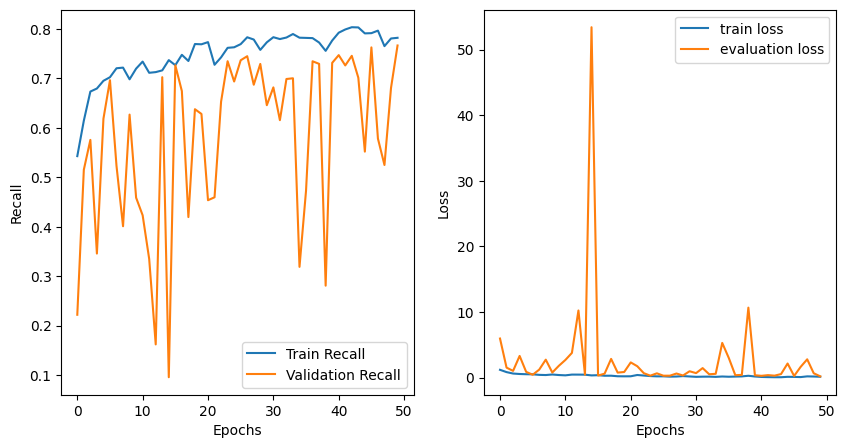

In [ ]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['mean_recall'], label='Train Recall');
ax.plot(history.history['val_mean_recall'], label='Validation Recall');
ax.set_xlabel('Epochs');
ax.set_ylabel('Recall');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');

In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = model1.predict(x_test)

# Obtener las etiquetas predichas para cada muestra en el conjunto de prueba
y_pred_labels = np.argmax(y_pred, axis=1)

# Obtener las etiquetas verdaderas para cada muestra en el conjunto de prueba
y_true_labels = np.argmax(y_test, axis=1)

# Calcular la matriz de confusión
confusion = confusion_matrix(y_true_labels, y_pred_labels)
print("Matriz de Confusión:")
print(confusion)

# Obtener los valores de la matriz de confusión para calcular precision y recall
tp = confusion.diagonal()  # True Positives
fp = confusion.sum(axis=0) - tp  # False Positives
fn = confusion.sum(axis=1) - tp  # False Negatives

# Calcular precision y recall
precision = tp / (tp + fp)
recall = tp / (tp + fn)


print("Precision:", precision)
print("Recall:", recall)
print("MeanRecall:",np.mean(recall))

94/94 [==============================] - 1s 6ms/step
Matriz de Confusión:
[[281  10   1   0   6   0   3   2   0   0]
 [  1 281  11   2   2   0   8   3   1   0]
 [  0  22 263   6   6   0   2   0   0   0]
 [  0   2   0 297   2   2   0   0   2   1]
 [  0   3   2   9 303   0   2   0   1   0]
 [  0   0   0   1   0 267  15   0   0   0]
 [  0   0   1   1   2  16 272   0   3   1]
 [  3   1   0   0   1   3   0 297   0   0]
 [  0   1   0   0   2   0   0   0 280   0]
 [  0   0   0   0   0   0   1   0   0 295]]
Precision: [0.98596491 0.878125   0.94604317 0.93987342 0.93518519 0.92708333
 0.89768977 0.98344371 0.97560976 0.99326599]
Recall: [0.92739274 0.90938511 0.87959866 0.97058824 0.946875   0.9434629
 0.91891892 0.97377049 0.98939929 0.99662162]
MeanRecall: 0.945601297320055


In [ ]:
#@title Planteamiento del modelo

# Crear la arquitectura de la red neuronal convolucional
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='elu', kernel_initializer='glorot_uniform', bias_initializer='he_uniform', padding='same', input_shape=(Tam_image, Tam_image, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='elu', kernel_initializer='glorot_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='elu', kernel_initializer='glorot_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='elu', kernel_initializer='glorot_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu', kernel_initializer='glorot_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='elu', kernel_initializer='glorot_uniform', bias_initializer='he_uniform', padding='same'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D(2),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(len(categorias), activation='softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 batch_normalization (BatchN  (None, 128, 128, 32)     128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 128, 128, 32)      9248      
                                                                 
 batch_normalization_1 (Batc  (None, 128, 128, 32)     128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                        

Epoch 1/50
219/219 [==============================] - 23s 39ms/step - loss: 2.6196 - precision: 0.5530 - val_loss: 20.7311 - val_precision: 0.1098
Epoch 2/50
219/219 [==============================] - 7s 32ms/step - loss: 0.8425 - precision: 0.7465 - val_loss: 12.8742 - val_precision: 0.3985
Epoch 3/50
219/219 [==============================] - 7s 32ms/step - loss: 0.6578 - precision: 0.7839 - val_loss: 1.9910 - val_precision: 0.6849
Epoch 4/50
219/219 [==============================] - 7s 32ms/step - loss: 0.5357 - precision: 0.8097 - val_loss: 0.7348 - val_precision: 0.7646
Epoch 5/50
219/219 [==============================] - 7s 32ms/step - loss: 0.4330 - precision: 0.8363 - val_loss: 1.0395 - val_precision: 0.7830
Epoch 6/50
219/219 [==============================] - 7s 32ms/step - loss: 0.3923 - precision: 0.8381 - val_loss: 0.4836 - val_precision: 0.8318
Epoch 7/50
219/219 [==============================] - 7s 32ms/step - loss: 0.3309 - precision: 0.8578 - val_loss: 0.5238 - val_

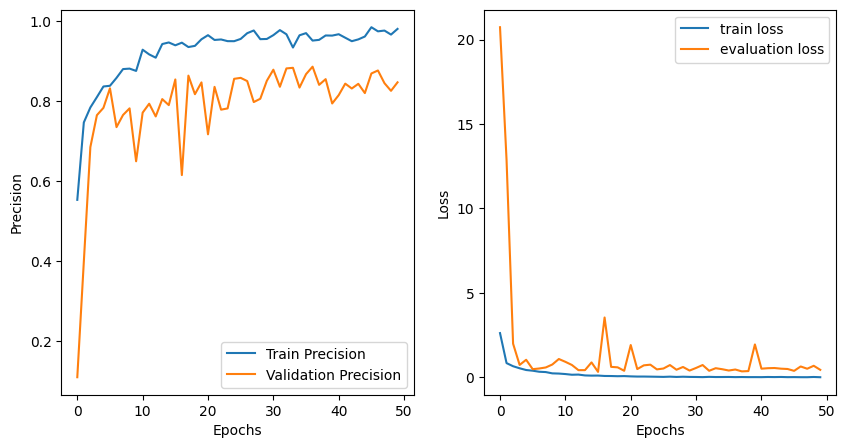

In [ ]:
# Compilar y entrenar el modelo
opt = tf.keras.optimizers.Adamax(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[precision_metric.precision])
history = model.fit(x_train, y_train, epochs=50,verbose=1, batch_size=32,validation_data=(x_test, y_test))

#Mostramos el desempeño de los datos por medio de imágenes
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['precision'], label='Train Precision');
ax.plot(history.history['val_precision'], label='Validation Precision');
ax.set_xlabel('Epochs');
ax.set_ylabel('Precision');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');



In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = model.predict(x_test)

# Obtener las etiquetas predichas para cada muestra en el conjunto de prueba
y_pred_labels = np.argmax(y_pred, axis=1)

# Obtener las etiquetas verdaderas para cada muestra en el conjunto de prueba
y_true_labels = np.argmax(y_test, axis=1)

# Calcular la matriz de confusión
confusion = confusion_matrix(y_true_labels, y_pred_labels)
print("Matriz de Confusión:")
print(confusion)

# Obtener los valores de la matriz de confusión para calcular precision y recall
tp = confusion.diagonal()  # True Positives
fp = confusion.sum(axis=0) - tp  # False Positives
fn = confusion.sum(axis=1) - tp  # False Negatives

# Calcular precision y recall
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print("Precision:", precision)
print("Recall:", recall)
print("Precision:",precision[2])

94/94 [==============================] - 1s 7ms/step
Matriz de Confusión:
[[262   1   1   0   4   0   0   3   0   0]
 [  9 238  15   1   9   6  20   4   0   0]
 [  3  11 258   1  12   1   5   3   1   0]
 [  1   3   6 266  16   3   4   1   3   1]
 [  1   6   2   2 272   0   6   0   4   0]
 [  0   2   0   1   3 268  22   0   1   0]
 [  0   6   1   0   6   4 288   0   3   0]
 [  0   0   0   0   1   4   0 311   0   0]
 [  0   0   0   0   1   0   0   0 288   0]
 [  0   0   0   0   1   2   5   0   0 317]]
Precision: [0.94927536 0.89138577 0.91166078 0.98154982 0.83692308 0.93055556
 0.82285714 0.96583851 0.96       0.99685535]
Recall: [0.96678967 0.78807947 0.87457627 0.875      0.92832765 0.9023569
 0.93506494 0.98417722 0.99653979 0.97538462]
Precision: 0.911660777385159


Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 134, 134, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 64, 64, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 64, 64, 64)   256         ['conv1_conv[0][0]']      

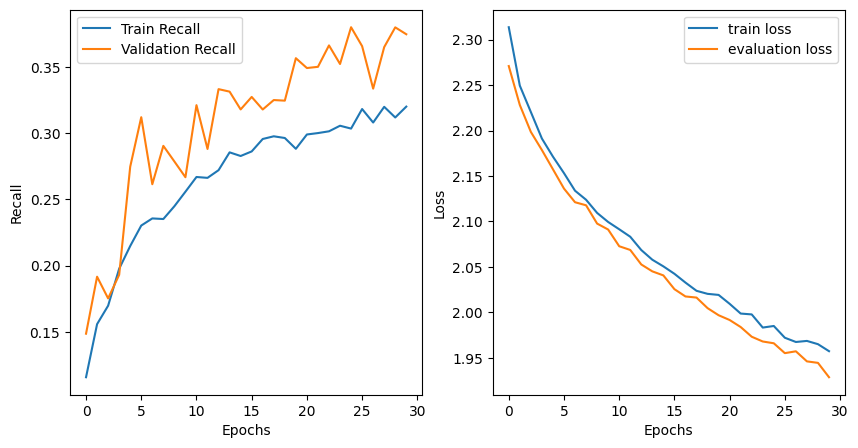

In [ ]:
#@title Probar con TL
model_A =  tf.keras.applications.ResNet50(input_shape=x_train[0].shape, weights='imagenet', include_top=False)
model_A.trainable = False
model_A.summary()

prediction_layer = tf.keras.layers.Dense(len(categorias), activation='softmax')
flatten_layer = tf.keras.layers.Flatten()
dropout_layer = tf.keras.layers.Dropout(0.3)
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()

model_B_on_A = tf.keras.Sequential([
  model_A,
  global_average_layer,
  dropout_layer,
  prediction_layer
])

learning_rate= 0.001
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_B_on_A.compile(optimizer=opt, loss='categorical_crossentropy',metrics=[mrecall_metric.mean_recall])
history = model_B_on_A.fit(x_train, y_train, epochs=30,verbose=1, batch_size=32,validation_data=(x_test, y_test))

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['mean_recall'], label='Train Recall');
ax.plot(history.history['val_mean_recall'], label='Validation Recall');
ax.set_xlabel('Epochs');
ax.set_ylabel('Recall');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');


In [ ]:
import gc
gc.collect()

26391

Total layers of ResNet50: 175
Total trainable layers: 132
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 23,147,530
Non-trainable params: 460,672
_________________________________________________________________
Epoch 1/20
219/219 [========================

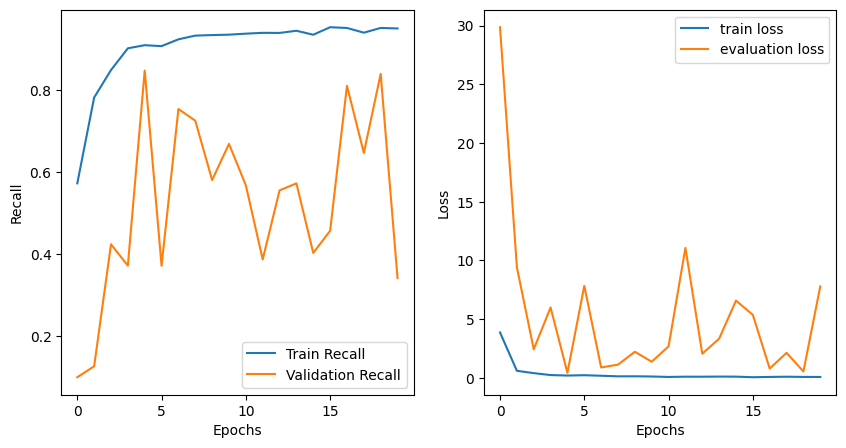

In [ ]:
model_A.trainable = True
print("Total layers of ResNet50:", len(model_A.layers))
for layer in model_A.layers[:int(len(model_A.layers) * 0.25)]:
    layer.trainable = False

print("Total trainable layers:", sum([1 for layer in model_A.layers if layer.trainable]))

model_B_on_A.summary()
len(model_B_on_A.trainable_variables)

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate / 10)
model_B_on_A.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[mrecall_metric.mean_recall])

# Entrenamiento descongelando el 75% restante
history = model_B_on_A.fit(x_train, y_train, epochs=20, verbose=1, batch_size=32, validation_data=(x_test, y_test))

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['mean_recall'], label='Train Recall');
ax.plot(history.history['val_mean_recall'], label='Validation Recall');
ax.set_xlabel('Epochs');
ax.set_ylabel('Recall');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');


In [ ]:
gc.collect()

9193

Total layers of ResNet50: 175
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 4, 4, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout_8 (Dropout)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 10)                20490     
                                                                 
Total params: 23,608,202
Trainable params: 23,555,082
Non-trainable params: 53,120
_________________________________________________________________
Epoch 1/20
219/219 [==============================] - 54s 70ms/step - los

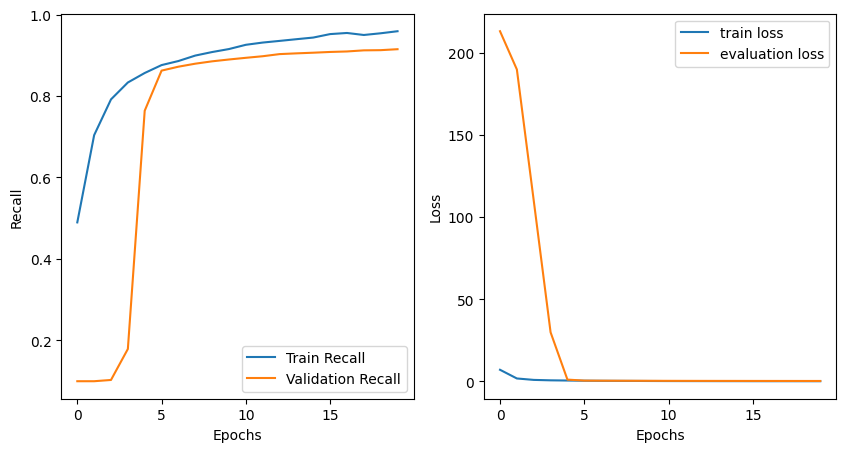

In [ ]:
model_A.trainable = True
print("Total layers of ResNet50:", len(model_A.layers))
model_B_on_A.summary()
len(model_B_on_A.trainable_variables)

opt = tf.keras.optimizers.Adam(learning_rate=learning_rate / 500)
model_B_on_A.compile(optimizer=opt, loss='categorical_crossentropy', metrics=[mrecall_metric.mean_recall])

# Entrenamiento con todos los parámetros descongelados
history = model_B_on_A.fit(x_train, y_train, epochs=20, verbose=1, batch_size=32, validation_data=(x_test, y_test))

import matplotlib.pyplot as plt
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['mean_recall'], label='Train Recall');
ax.plot(history.history['val_mean_recall'], label='Validation Recall');
ax.set_xlabel('Epochs');
ax.set_ylabel('Recall');
ax.legend();
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['loss'], label='train loss');
ax.plot(history.history['val_loss'], label='evaluation loss');
ax.legend();
ax.set_xlabel('Epochs');
ax.set_ylabel('Loss');


In [ ]:
from sklearn.metrics import confusion_matrix, precision_recall_curve

# Obtener las predicciones del modelo en el conjunto de prueba
y_pred = model_B_on_A.predict(x_test)

# Obtener las etiquetas predichas para cada muestra en el conjunto de prueba
y_pred_labels = np.argmax(y_pred, axis=1)

# Obtener las etiquetas verdaderas para cada muestra en el conjunto de prueba
y_true_labels = np.argmax(y_test, axis=1)

# Calcular la matriz de confusión
confusion = confusion_matrix(y_true_labels, y_pred_labels)
print("Matriz de Confusión:")
print(confusion)

# Obtener los valores de la matriz de confusión para calcular precision y recall
tp = confusion.diagonal()  # True Positives
fp = confusion.sum(axis=0) - tp  # False Positives
fn = confusion.sum(axis=1) - tp  # False Negatives

# Calcular precision y recall
precision = tp / (tp + fp)
recall = tp / (tp + fn)

print("Precision:", precision)
print("Recall:", recall)
print("MeanRecall:",np.mean(recall))

94/94 [==============================] - 2s 14ms/step
Matriz de Confusión:
[[278  10   3   1   5   0   3   3   0   0]
 [  4 272  14   3   4   5   7   0   0   0]
 [  1  15 277   3   1   0   2   0   0   0]
 [  1   2   2 295   3   0   1   2   0   0]
 [  5   3   2   3 300   1   5   0   1   0]
 [  0   3   0   0   0 272   8   0   0   0]
 [  1   9   0   3   2  17 260   0   0   4]
 [  5   0   0   1   0   1   0 297   1   0]
 [  0   0   0   0   2   0   0   0 281   0]
 [  0   0   0   0   0   1   3   0   0 292]]
Precision: [0.94237288 0.86624204 0.9295302  0.95469256 0.94637224 0.91582492
 0.89965398 0.98344371 0.99293286 0.98648649]
Recall: [0.91749175 0.8802589  0.9264214  0.96405229 0.9375     0.96113074
 0.87837838 0.97377049 0.99293286 0.98648649]
MeanRecall: 0.9418423302023692
